# Training Fraud Detection Data

In [45]:
import pandas as pd
import numpy as np
from scipy import interp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns



%matplotlib inline

## Prepare Training/Testing Data

In [2]:
dat = pd.read_csv('./../data/explored.csv')

In [3]:
final_cols = ['merchantidentifier','first_transaction_amount','time_to_first_txn','loc_hmg_coeff','org_fraud_prevalence','is_fraud']

In [4]:
dat_sub = dat[final_cols]

In [5]:
#convert loc_hmg_coeff into a categorical so that the trees traverse each similarity category
dat_sub = pd.get_dummies(dat_sub, columns=['loc_hmg_coeff'])

In [6]:
dat_sub.sample(3)

,merchantidentifier,first_transaction_amount,time_to_first_txn,org_fraud_prevalence,is_fraud,loc_hmg_coeff_0.25,loc_hmg_coeff_0.5,loc_hmg_coeff_0.75,loc_hmg_coeff_1.0
75233,19800110293,481.26,0,0.024647,1,0.0,0.0,0.0,1.0
14681,32239405,1.00,2,0.043887,0,0.0,0.0,0.0,1.0
100391,19844187059,14.99,18,0.025276,0,0.0,0.0,0.0,1.0


In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dat_sub[['first_transaction_amount','time_to_first_txn','loc_hmg_coeff_0.25','loc_hmg_coeff_0.5','loc_hmg_coeff_0.75','loc_hmg_coeff_1.0','org_fraud_prevalence']],
                                                dat_sub[['is_fraud']], train_size=0.75)

In [8]:
Xtrain.to_csv('./../data/xtrain.csv', index=False)
ytrain.to_csv('./../data/ytrain.csv', index=False)
Xtest.to_csv('./../data/xtest.csv', index=False)
ytest.to_csv('./../data/ytest.csv', index=False)

# Test Strategy 

## Part 1: Cost Sensitive Learning Approaches  
### Weighting Imabalanced Class  

Here, we train an ensemble classifier with weights inversely proportional to the class proportions. This indicates to the algorithm that the cost of mis-classifying the rare class is more severe than correctly classifying the majority class. 

In [9]:
cv = StratifiedKFold(np.array(ytrain).ravel(), n_folds=10)
#weights = np.array()
rf1 = RandomForestClassifier(n_estimators=30, verbose=0, criterion='gini', n_jobs=-1, class_weight='balanced')

In [10]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

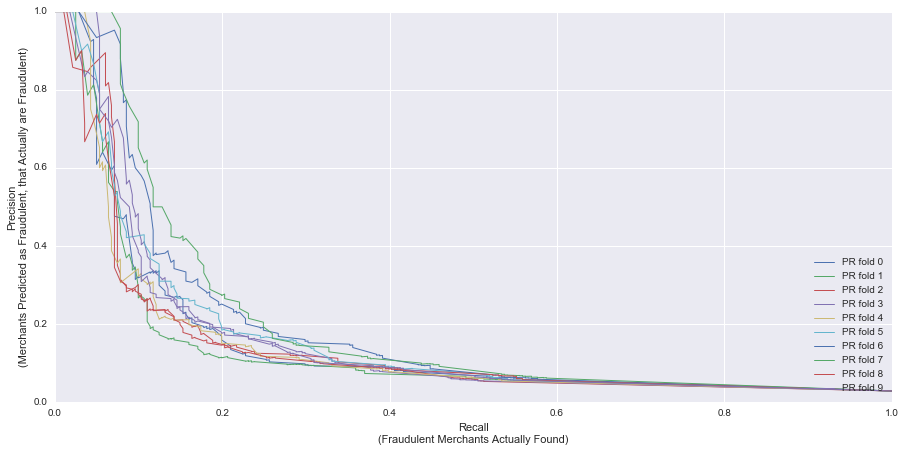

In [13]:
plt.figure(figsize=(15,7))
for i, (train, test) in enumerate(cv):
    rf1.fit(Xtrain.iloc[train], np.array(ytrain.iloc[train]).ravel(), sample_weight=np.where(ytrain.iloc[train]==1, 1.0, 33.0).ravel())
    probas_ = rf1.predict_proba(Xtrain.iloc[test])
    #Compute P-R curve
    precision, recall, thresholds = precision_recall_curve(ytrain.iloc[test], probas_[:,1], pos_label=1) #sample_weight=np.where(ytrain.iloc[train]==1, 1.0, 30.0).ravel())
    plt.plot(recall, precision, lw=1, label='PR fold %d'%i)
    #plt.plot(recall, thresholds, lw=2)
    
    
    # Compute ROC curve and area under the curve
#     fpr, tpr, thresholds = roc_curve(ytrain.iloc[test], probas_[:, 1], pos_label=1)
#     mean_tpr += interp(mean_fpr, fpr, tpr)
#     mean_tpr[0] = 0.0
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
#     plt.plot(fpr, thresholds, lw=2)

    
#plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
#mean_tpr /= len(cv)
#mean_tpr[-1] = 1.0
#mean_auc = auc(mean_fpr, mean_tpr)
#plt.plot(mean_fpr, mean_tpr, 'k--',
#         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate\n(Genuine Merchants Incorrectly Classified as Fraud)')
# plt.ylabel('True Positive Rate\n(Fraudulent Merchants Correctly Classified as Fraud)')
# plt.title('Receiver operating characteristic\nRandom Forest Classifier (No Cost Penalization)')

plt.xlabel('Recall\n(Fraudulent Merchants Actually Found)')
plt.ylabel('Precision\n(Merchants Predicted as Fraudulent, that Actually are Fraudulent)')
plt.title('Receiver operating characteristic\nRandom Forest Classifier (No Cost Penalization)')

plt.legend(loc="lower right")
plt.show()


In [32]:
rf1.fit(Xtrain, np.array(ytrain).ravel(), sample_weight=np.where(ytrain==1, 1.0, 33.0).ravel())
ypred = (rf1.predict_proba(Xtest)[:,1] > 0.05).astype(int)

In [33]:
print(classification_report(ytest, ypred, labels=[1,0], target_names=['fraud','not fraud']))
#print(confusion_matrix(ytest, ypred, labels=[1,0]))

             precision    recall  f1-score   support

      fraud       0.09      0.41      0.15       961
  not fraud       0.98      0.88      0.93     31761

avg / total       0.95      0.86      0.90     32722



In [34]:
print(confusion_matrix(ytest, ypred, labels=[1,0]))

[[  397   564]
 [ 3914 27847]]


### Cost Based Learning: Thresholding  

In [36]:
scores=[]

for val in range(1, 100, 10):
    rf_thresh1 = RandomForestClassifier(n_estimators=val, n_jobs=-1, class_weight='balanced_subsample')
    validated = cross_val_score(rf_thresh1, Xtrain, np.array(ytrain).ravel(), cv=10, scoring='f1')
    scores.append(validated)

In [37]:
validated

array([ 0.13333333,  0.10958904,  0.1184669 ,  0.11663808,  0.1163522 ,
        0.13080895,  0.13490725,  0.12587413,  0.09677419,  0.10469314])

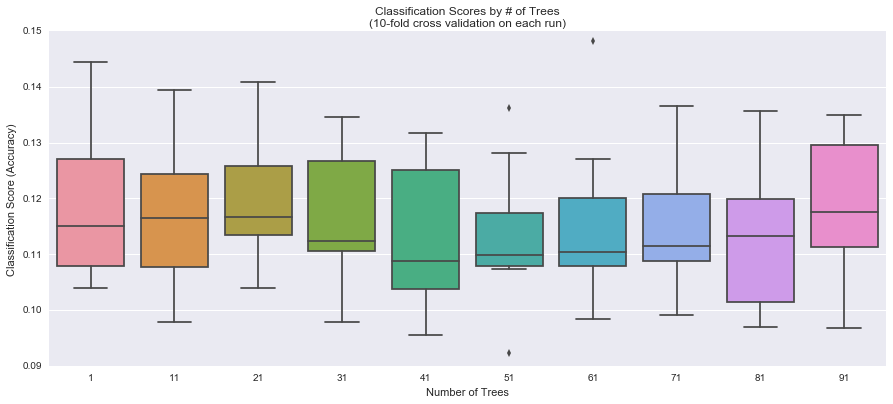

In [39]:
plt.figure(figsize=(15,6))
sns.boxplot(y=scores, x=range(1,100,10))
plt.xlabel('Number of Trees')
plt.ylabel('Classification Score (Accuracy)')
plt.title('Classification Scores by # of Trees\n(10-fold cross validation on each run)')


In [282]:
#Use 20 trees!

In [344]:
#tune decision threshold
def custom_f1(cutoff):
    rf_thresh2.fit(Xtrain, np.array(ytrain).ravel())
    ypred = (rf_thresh2.predict_proba(Xtrain)[:,1] > cutoff).astype(int)
    return f1_score(ytrain, ypred)

In [345]:
# from sklearn.metrics import make_scorer
# scores=[]
# for cutoff in np.arange(0.1, 0.9, 0.1):
#     rf_thresh2 = RandomForestClassifier(n_estimators=30, n_jobs=-1)
#     #rf_thresh2.fit(Xtrain,ytrain)
#     validated = cross_val_score(rf_thresh2, Xtrain, np.array(ytrain).ravel(), cv=10, scoring=custom_f1(cutoff))
#     scores.append(validated)

TypeError: 'numpy.float64' object is not callable

In [40]:
scores = []
cutoff_val=[]
rf_thresh2 = RandomForestClassifier(n_estimators=20, n_jobs=-1)
rf_thresh2.fit(Xtrain, np.array(ytrain).ravel())
for cutoff in np.arange(0.1,0.9,0.05):
    ypred = (rf_thresh2.predict_proba(Xtest)[:,1] > cutoff).astype(int)
    cutoff_val.append(cutoff)
    scores.append(f1_score(ytest, ypred))

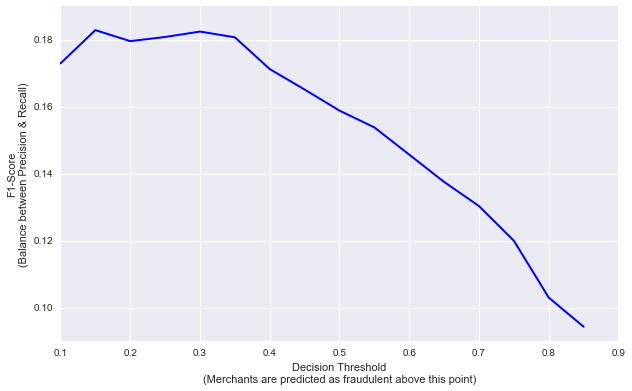

In [41]:
plt.figure(figsize=(10,6))
plt.plot(cutoff_val,scores, 'b-', linewidth=2)
plt.xlabel('Decision Threshold\n(Merchants are predicted as fraudulent above this point)')
plt.ylabel('F1-Score\n(Balance between Precision & Recall)')

In [410]:
#ideal decision threshold is between 0.2 and 0.4... approx. 0.25-0.3
ypred = (rf_thresh2.predict_proba(Xtest)[:,1] > 0.25).astype(int)

In [411]:
f1_score(ytest, ypred)

0.20536635706914344

# Part 2: Sampling Approaches

Synthetic Minority Oversampling TEchnique

In [46]:
smote = SMOTE(ratio='auto',k=5,m=10,n_jobs=-1)

In [48]:
X_res, y_res = smote.fit_sample(Xtrain, np.array(ytrain).ravel())

In [52]:
from collections import Counter

In [58]:
ytrain.groupby(by='is_fraud').size()

is_fraud
0    95356
1     2810
dtype: int64

In [53]:
Counter(y_res)

Counter({0: 95356, 1: 95356})

In [62]:
param_grid = { 
    'n_estimators': [1, 10, 20, 30, 50, 100, 250, 1000],
    'criterion': ['gini','entropy'],
    'max_depth': [5, 10, 20, 30, 50, 100, 250, 1000],
    'min_samples_split': [2, 3, 5, 7, 10, 15, 20, 50]
}

In [66]:
clf1 = RandomForestClassifier(n_jobs=-1, oob_score=True)

In [67]:
GSCV = GridSearchCV(estimator=clf1, param_grid=param_grid, scoring='f1', n_jobs=-1, cv = 5)

In [ ]:
GSCV.fit(Xtrain, np.array(ytrain).ravel())

/Users/ash/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ash/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ash/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ash/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some i

In [159]:
rf1 = RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs=-1, verbose=1)

In [160]:
rf1.fit(Xtrain, ytrain)

/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=True, random_state=None, verbose=1, warm_start=False)

In [161]:
rf1.oob_decision_function_

array([[ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       ..., 
       [ 1.        ,  0.        ],
       [ 0.66018519,  0.33981481],
       [ 1.        ,  0.        ]])

In [162]:
rf1.oob_score_

0.96763645253957586

In [164]:
print(classification_report(ytrain, rf1.predict(Xtrain)))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


             precision    recall  f1-score   support

          0       0.99      1.00      1.00     95311
          1       0.98      0.77      0.86      2855

avg / total       0.99      0.99      0.99     98166



In [35]:
rf1.predict_proba(Xtest)

array([[ 0.96666667,  0.03333333],
       [ 1.        ,  0.        ],
       [ 0.99655296,  0.00344704],
       ..., 
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ]])

In [ ]:
cross_val_score()

## Cost Sensitive Learning  

Assigning a high cost to misclassification of the minority class, and trying to minimize the overall cost. Reference: http://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf

We propose two ways to deal with the problem of extreme imbalance, both based on the random Forest
(RF) algorithm (Breiman, 2001). One incorporates class weights into the RF classifier, thus making it cost
sensitive, and it penalizes misclassifying the minority class. The other combines the sampling technique
and the ensemble idea. It down-samples the majority class and grows each tree on a more balanced data
set. A majority vote is taken as usual for prediction.  

However, similar to most classifiers, RF can also suffer from the curse of learning
from an extremely imbalanced training data set. As it is constructed to minimize the overall error rate, it
will tend to focus more on the prediction accuracy of the majority class, which often results in poor accuracy
for the minority class. To alleviate the problem, we propose two solutions: balanced random forest (BRF)
and weighted random forest (WRF).

Balanced Random Forest  

As recent
research shows (e.g., Ling & Li (1998),Kubat & Matwin (1997),Drummond & Holte (2003)), for the tree
classifier, artificially making class priors equal either by down-sampling the majority class or over-sampling
the minority class is usually more effective with respect to a given performance measurement, and that downsampling
seems to have an edge over over-sampling. However, down-sampling the majority class may result
in loss of information, as a large part of the majority class is not used. Random forest inspired us to ensemble
trees induced from balanced down-sampled data. The Balanced Random Forest (BRF) algorithm is shown
below:
1. For each iteration in random forest, draw a bootstrap sample from the minority class. Randomly draw
the same number of cases, with replacement, from the majority class.
2. Induce a classification tree from the data to maximum size, without pruning. The tree is induced with
the CART algorithm, with the following modification: At each node, instead of searching through all
variables for the optimal split, only search through a set of mtry randomly selected variables.
3. Repeat the two steps above for the number of times desired. Aggregate the predictions of the ensemble
and make the final prediction.

Weighted Random Forest  

Another approach to make random forest more suitable for learning from extremely imbalanced data follows
the idea of cost sensitive learning. Since the RF classifier tends to be biased towards the majority class, we
shall place a heavier penalty on misclassifying the minority class. We assign a weight to each class, with the
minority class given larger weight (i.e., higher misclassification cost). The class weights are incorporated
into the RF algorithm in two places. In the tree induction procedure, class weights are used to weight
the Gini criterion for finding splits. In the terminal nodes of each tree, class weights are again taken into
consideration. The class prediction of each terminal node is determined by “weighted majority vote”; i.e.,
the weighted vote of a class is the weight for that class times the number of cases for that class at the
terminal node. The final class prediction for RF is then determined by aggregatting the weighted vote from
each individual tree, where the weights are average weights in the terminal nodes. Class weights are an
essential tuning parameter to achieve desired performance. The out-of-bag estimate of the accuracy from
RF can be used to select weights.

In [3]:
np.bincount(np.array([0,0,1,1,2,1,1]))

array([2, 4, 1])

In [4]:
y = [1, 0, 1, 1, 1, 1, 0, 0, 1, 1]

In [7]:
(2*np.bincount(y))

array([ 6, 14])

In [11]:
10.0/np.array([6,14])

array([ 1.66666667,  0.71428571])